In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from netCDF4 import Dataset
import statsmodels.api as sm


##  Load input reservoir data

In [2]:
Res_CH4 = pd.read_excel('Table S7 Reservoir subset metadata.xlsx', skiprows = [0])

Res_CH4 = Res_CH4.fillna(0)  
Res_CH4.rename(columns = {'Dam/Reservoir name':'System'}, inplace = True)   #simplify column mame

#truncate input table to include only the input parameters
idx = Res_CH4.columns.get_loc('Measured_CH4_eb+diff_mgCH4-C_m-2_d-1')    
Res_CH4 = Res_CH4.iloc[:, 0:idx+1]



### Add meteo data (average annual temperature from MERRA2)

In [3]:
# # Extract annual average temperature information

# are_f = Dataset('T2M_annual.merra2.01x01.2015.nc')
# Temp_All = np.array(are_f.variables['GMAO_2D__T2M'])[0,:,:]   
# are_f.close()

# for reservoir in np.arange(len(Res_CH4)):

#     Lati = int((Res_CH4.loc[reservoir,'Latitude']+90))
#     Loni = int((Res_CH4.loc[reservoir,'Longitude']+180))

#     Res_CH4.loc[reservoir,'Temp'] = Temp_All[int(Lati/0.1),int(Loni/0.1)]  #need to divide by 0.1 here beause Temp_All is 10 times as big as other arrays!



## Estimate flooded carbon input

## First, unzip Carbon_Pools_Ann file

In [4]:
#Flooded carbon inputs are the carbon amounts present in the landscape prior to reservoir flooding.  The carbon pools are
#'carbs','leaves','fine_roots','wood','wood_debris','surfmet','surfstruct','surfmic','soilmet','soilstruct','soilmic','soilslow','soilarm'
#as defined in Schaefer, K., James Collatz, G., Tans, P., Scott Denning, A., Baker, I., Berry, J., Prihodko, L., Suits, N., et al. (2008). Combined Simple Biosphere/Carnegie-Ames-Stanford Approach terrestrial carbon cycle model. Journal of Geophysical Research, 113(G3). https://doi.org/10.1029/2007jg000603

Carbon_Pools_Ann= np.load('Carbon_Pools_Ann.npy')   # kg/m2 
Carbon_Pools_Ann = Carbon_Pools_Ann * 1000000   #mg C/m2

pools = pd.DataFrame(columns=['carbs','leaves','fine_roots','wood','wood_debris','surfmet','surfstruct','surfmic','soilmet','soilstruct','soilmic','soilslow','soilarm'])

#extract carbon amounts in each SibCASA carbon pool at each reservoir site (based on lat/lon)
for reservoir in np.arange(len(Res_CH4)):

    lati_carbonAnn = int((Res_CH4.loc[reservoir,'Latitude']+90)/float(0.5))  #divide by 0.5 here because there are 2 values per degree
    loni_carbonAnn = int((Res_CH4.loc[reservoir,'Longitude']+180)/float(0.5))

    pools.loc[reservoir,'System'] = Res_CH4.loc[reservoir,'System']
    pools.loc[reservoir,'carbs'] = Carbon_Pools_Ann[0,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'leaves'] = Carbon_Pools_Ann[1,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'fine_roots'] = Carbon_Pools_Ann[2,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'wood'] = Carbon_Pools_Ann[3,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'wood_debris'] = Carbon_Pools_Ann[4,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'surfmet'] = Carbon_Pools_Ann[5,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'surfstruct'] = Carbon_Pools_Ann[6,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'surfmic'] = Carbon_Pools_Ann[7,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'soilmet'] = Carbon_Pools_Ann[8,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'soilstruct'] = Carbon_Pools_Ann[9,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'soilmic'] = Carbon_Pools_Ann[10,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'soilslow'] = Carbon_Pools_Ann[11,lati_carbonAnn,loni_carbonAnn]   # mg/m2
    pools.loc[reservoir,'soilarm'] = Carbon_Pools_Ann[12,lati_carbonAnn,loni_carbonAnn]   # mg/m2

#Since wood decay is very slow, we exclude wood and woody debris from the flooded carbon inputs 
pools['sumcols_nowood'] =  pools[['carbs','leaves','fine_roots', 'surfmet','surfstruct','surfmic','soilmet','soilstruct','soilmic']].sum(axis=1)

#add carbon amount to main dataframe
if 'sumcols_nowood' not in Res_CH4.columns:
    Res_CH4 = pd.merge(Res_CH4, pools[['System', 'sumcols_nowood']], on = 'System', how = 'left')
    


## Estimation primary production

In [5]:
#Estimate primary production using trophic status reported in literature.  

Res_CH4['Primary_Prod'] = 0.0  #initialize

#based on reservoir values in Table 15-12 of Wetzel, R. (2001). Limnology: Lake and River Ecosystems (Vol. 3). San Diego, California, Academic Press.:
primeprod = np.array([151, 0.5*(151+570), 570, 0.5*(570 + 2019), 2019])  #primary production (mg C/m2/day) values for oligotrophic, oligomesotrophic, mesotrophic, mesoeutrophic, and eutrophic systems, respectively

for ni in np.arange(len(Res_CH4)):

    if Res_CH4.loc[ni,'Trophic_Status'] == 'Oligotrophic':
        Res_CH4.loc[ni,'Primary_Prod'] = primeprod[0]   # mg C/ m2/ day
               
    elif Res_CH4.loc[ni,'Trophic_Status'] == 'Oligo_Meso':
        Res_CH4.loc[ni,'Primary_Prod'] = primeprod[1] # mg C/ m2/ day
                
    elif Res_CH4.loc[ni,'Trophic_Status'] == 'Mesotrophic':
        Res_CH4.loc[ni,'Primary_Prod'] = primeprod[2] # mg C/ m2/ day
                        
    elif Res_CH4.loc[ni,'Trophic_Status'] == 'Meso_Eutrophic':
        Res_CH4.loc[ni,'Primary_Prod'] = primeprod[3] # mg C/ m2/ day
           
    elif Res_CH4.loc[ni,'Trophic_Status'] == 'Eutrophic':
        Res_CH4.loc[ni,'Primary_Prod'] = primeprod[4] # mg C/ m2/ day
        

## Estimate allochthonous carbon inputs

In [6]:
#Estimate allochthonous carbon inputs, both as particulate organic carbon (POC) and dissolved organic carbon (DOC), using 
#parameters such as watershed relief, flow rate, and latitude.

Res_CH4['ALLOC_POC'] = 0   #initialize value
Res_CH4['ALLOC_DOC'] = 0   #initialize value

#calculate watershed relief (the elevation difference between the reservoir and the highest point in the watershed)
Res_CH4['Relief'] = Res_CH4['Max_watershed_elev']  -  Res_CH4['Dam_Elevation_msl']  
#*********************************************************************

#Calculate regression parameters for fit between % of DOC that flocculates daily, and temperature 
# data from Wachenfeldt, E. von, Bastviken, D., & Tranvika, L. J. (2009). Microbially induced flocculation of allochthonous dissolved organic carbon in lakes. Limnology and Oceanography, 54(5), 1811–1818. https://doi.org/10.4319/lo.2009.54.5.1811.
temps = [4, 10, 20]   #experimental temperatures
floc_rate = np.array([3.4, 8.8, 11.0])/25/1000  #mgC/day, where 25mg/L is the approximate starting DOC value and units for 3.4, 8.8, and 11.0 are ugC / L / day 
slope, intercept, r_value, p_value, std_err = stats.linregress(temps,floc_rate)  #use these later on


#**********************************************************************

#Estimate POC inputs, then estimate DOC as a fraction of POC
for reservoir in np.arange(len(Res_CH4)):
    
    #******************************************************************************
    #calculate average flow rate through reservoir
    Res_CH4.loc[reservoir,'Flow_rate_m3_sec-1'] = Res_CH4.loc[reservoir,'Volume_km3'] / Res_CH4.loc[reservoir,'Residence_Time_days'] *1000**3 / (60*60*24) 
    
    #IF calculated flow rate is zero because we do not have a reservoir volume estimate, use literature value for flow rate
    if Res_CH4.loc[reservoir,'Flow_rate_m3_sec-1'] == 0:
        Res_CH4.loc[reservoir,'Flow_rate_m3_sec-1'] = Res_CH4.loc[reservoir,'Flow_rate_(needed_when_volume_is_unknown)']

    
    #******************************************************************************   
    #Calculate sediment input (where allochthonous inputs will be a fraction of sediment input)
    #use methods and parameters from Syvitski, J. P. M., Peckham, S. D., Hilberman, R., & Mulder, T. (2003). Predicting the terrestrial flux of sediment to the global ocean: a planetary perspective. Sedimentary Geology, 162(1), 5–24. https://doi.org/10.1016/S0037-0738(03)00232-X.
    if Res_CH4.loc[reservoir,'Latitude'] > 30:
        alpha6 = 1.1*10**-3
        alpha7 = 0.53
        alpha8 = 1.1
        k = 0.06
        T = 10
        
    elif 0 < Res_CH4.loc[reservoir,'Latitude'] < 30:
        alpha6 = 2
        alpha7 = 0.45
        alpha8 = 0.57
        k = -0.09
        T = 25
        
    elif -30 < Res_CH4.loc[reservoir,'Latitude'] < 0:
        alpha6 = 162
        alpha7 = 0.65
        alpha8 = -0.05
        k = -0.16
        T = 25
   

    Qs_kgyr = alpha6 * Res_CH4.loc[reservoir,'Flow_rate_m3_sec-1']**alpha7 * Res_CH4.loc[reservoir,'Relief']**alpha8 * np.exp(k*T) * 60*60*24*365  # kg sediment/year
    Qs_mgL = Qs_kgyr * 1000 * Res_CH4.loc[reservoir,'Residence_Time_days']/365 / (Res_CH4.loc[reservoir,'Volume_km3'] * 1000**3)
    
    #For several reservoirs, we do not have volume information but we do have flow rate - use this to calculate Qs_mgL
    if Res_CH4.loc[reservoir,'Volume_km3'] == 0:  #several reservoirs do not have volume estimates
        Qs_mgL = Qs_kgyr * 1e6 / Res_CH4.loc[reservoir,'Flow_rate_m3_sec-1'] / (60*60*24*365) / (1e3)
         
    
    Res_CH4.loc[reservoir,'Qs_mgL'] = Qs_mgL
    
    
    #***********************************************************************************
    #Estimate the fraction of DOC to TOC in 
    
    if Qs_mgL < 15:
        DOC_TOC_ratio = 85   #%, extracted from Fig. 2 in Meybeck
        
    elif 15 < Qs_mgL < 50:
        DOC_TOC_ratio = 70   #%, extracted from Fig. 2 in Meybeck
        
    elif 50 < Qs_mgL < 150:
        DOC_TOC_ratio = 55   #%, extracted from Fig. 2 in Meybeck
        
    elif 150 < Qs_mgL < 500:
        DOC_TOC_ratio = 45   #%, extracted from Fig. 2 in Meybeck
        
    elif 500 < Qs_mgL < 1500:
        DOC_TOC_ratio =  25  #%, extracted from Fig. 2 in Meybeck
        
    elif 1500 < Qs_mgL < 5000:
        DOC_TOC_ratio =   10 #%, extracted from Fig. 2 in Meybeck - plot doesn't go up this high
        
    elif 5000 < Qs_mgL < 15000:
        DOC_TOC_ratio =   10 #%, extracted from Fig. 2 in Meybeck - plot doesn't go up this high
        
    elif Qs_mgL > 15000:
        DOC_TOC_ratio =   10 #%, extracted from Fig. 2 in Meybeck - plot doesn't go up this high

        

    #*********************************************************************************
    #estimate the fraction of incoming sediment that is POC
    #equation below is from Beusen, A. H. W., Dekkers, A. L. M., Bouwman, A. F., Ludwig, W., & Harrison, J. (2005). Estimation of global river transport of sediments and associated particulate C, N, and P. Global Biogeochemical Cycles, 19(4). https://doi.org/10.1029/2005GB002453.
  
    POC_fraction = (1/100) * (-0.16*(np.log10(Res_CH4.loc[reservoir,'Qs_mgL']))**3 + 2.83 *(np.log10(Res_CH4.loc[reservoir,'Qs_mgL'] ))**2 - 13.6 *np.log10(Res_CH4.loc[reservoir,'Qs_mgL'] ) + 20.3)
           
    Res_CH4.loc[reservoir,'ALLOC_POC'] = Qs_kgyr /(Res_CH4.loc[reservoir,'Surface_Area_km2'] * 1000**2) * 1000000 * POC_fraction  #milligrams allochthonous matter per m2 reservoir per year
    Res_CH4.loc[reservoir,'ALLOC_DOC'] = DOC_TOC_ratio/100 * Res_CH4.loc[reservoir,'ALLOC_POC'] / (1-DOC_TOC_ratio/100)  #mg/m2/year
    
    #**********************************************************************************
    #Now estimate DOC input and flocculation (not all DOC will reach the sediment, so we need to estimate how much flocculates)

    flocc_rate = slope*(Res_CH4.loc[reservoir,'Mean_Annual_Temp_C']) + intercept   #daily flocculation rate, slope, intercept determined above
    Res_CH4.loc[reservoir,'ALLOC_DOC'] = Res_CH4.loc[reservoir,'ALLOC_DOC'] * (flocc_rate*365) #mg/m2/year

    #****************************************************************************************************
    #estimate reservoir trapping efficiency
    
    Res_CH4.loc[reservoir,'Trap_eff'] = 0.3  #global average sediment trapping
    if Res_CH4.loc[reservoir,'Volume_km3'] > 0.5: #for reservoirs larger than 0.5 km3, see Vörösmarty, C. J., Meybeck, M., Fekete, B., Sharma, K., Green, P., & Syvitski, J. P. M. (2003). Anthropogenic sediment retention: major global impact from registered river impoundments. Global and Planetary Change, 39(1), 169–190. https://doi.org/10.1016/S0921-8181(03)00023-7.
        Res_CH4.loc[reservoir,'Trap_eff'] = 1-(0.05/((Res_CH4.loc[reservoir,'Residence_Time_days']/365)**0.5))


#Calculate total carbon inputs to reservoir sediment from allochthonous POC and DOC
Res_CH4['ALLOC_DOC'] = Res_CH4['ALLOC_DOC'] * Res_CH4['Trap_eff']/365  #convert from years to days, result in mg/m2/day
Res_CH4['ALLOC_POC'] = Res_CH4['ALLOC_POC'] * Res_CH4['Trap_eff'] /365 #mg/m2/day


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars


# Estimation epilimnetic area fraction 

In [7]:
## Calculate fraction of reservoir above and below 5m depth

epi_fraction = np.zeros(len(Res_CH4))

for row in np.arange(len(Res_CH4)):

    if Res_CH4.loc[row,'Have_pseudobathymetry'] == 'yes':    #only run through loop for reservoirs where we have pseudo bathymetry
        system = Res_CH4.loc[row, 'System']
        
        #define filenames
        filename_hist = 'pseudo bathymetry_names/PseudoBath_hist_' + system + '.npy'
        filename_binedge = 'pseudo bathymetry_names/PseudoBath_binedge_' + system + '.npy'

        H_crit_depth = 5    #We assume that any depth below 5 m is in the hypolimnion

        hist = np.load(filename_hist)
        hist_bin = np.load(filename_binedge)

        #find all hist_bin below H_crit
        idx = hist_bin < H_crit_depth   
        epi_sum = [sum(hist[0:0+sum(idx)])]   # total # of grid boxes above H_crit
        area_tot = sum(hist)   #total # of grid boxes in reservoir

        Res_CH4.loc[row,'SA_epi_frac'] = epi_sum / area_tot
        
#for reservoirs where we do not have estimated bathymetry, assume the split between epilimnetic sediment and hypolimnetic sediments is 50/50
Res_CH4['SA_epi_frac'] = Res_CH4['SA_epi_frac'].fillna(0)
Res_CH4.loc[Res_CH4['SA_epi_frac'] == 0.0 , 'SA_epi_frac'] = 0.5
Res_CH4['SA_hypo_frac'] = 1 - Res_CH4['SA_epi_frac']

## Estimate sediment temperature

In [8]:
#**********************************************************
#Calculate hypolimnetic sediment temperature (Equation S8 in Supporting Information)

Res_CH4['Tx_hypo']= np.nan
for row in np.arange(len(Res_CH4['Latitude'])):   
    if abs(Res_CH4.loc[row,'Latitude']) <= 40:
        Res_CH4.loc[row,'Tx_hypo'] = 28.1 - 0.6*abs(Res_CH4.loc[row,'Latitude'])  #from Imberger, J., & Patterson, J. C. (1989). Physical Limnology. In J. W. Hutchinson & T. Y. Wu (Eds.), Advances in Applied Mechanics (Vol. 27, pp. 303–475). Elsevier. https://doi.org/10.1016/S0065-2156(08)70199-6
    else:
        Res_CH4.loc[row,'Tx_hypo'] = 4


#**********************************************************
#Estimate maximum water temperature (Equation S7 in Supporting Information)

#First extract MERRA2 data for January and July (needed to estimate epilimnetic sediment temperature)
jan_T2M = Dataset('MERRA2.201301.T2M.1x1.monmean.nc')
jan_T2M = np.array(jan_T2M.variables['T2M'])[0,:,:]   #1801 rows, 3601 columns
jul_T2M = Dataset('MERRA2.201307.T2M.1x1.monmean.nc')
jul_T2M = np.array(jul_T2M.variables['T2M'])[0,:,:]   #1801 rows, 3601 columns

Res_CH4['July_Temp'] = 0
Res_CH4['Jan_Temp'] = 0
for i in np.arange(len(Res_CH4)):

    Lati = int(Res_CH4.loc[i,'Latitude']+90)
    Loni = int(Res_CH4.loc[i,'Longitude']+180)
    
    Res_CH4.loc[i,'July_Temp'] = jul_T2M[Lati,Loni]
    Res_CH4.loc[i,'Jan_Temp'] = jan_T2M[Lati,Loni]

#Define two necessary variables 
Jm = 171+29  #Julian date of maximum surface temperature (from Minns, C. K., & Shuter, B. J. (2013). A semi-mechanistic seasonal temperature-profile model (STM) for the period of stratification in dimictic lakes. Canadian Journal of Fisheries and Aquatic Sciences. Journal Canadien Des Sciences Halieutiques et Aquatiques, 70(2), 169–181. https://doi.org/10.1139/cjfas-2012-0253)
beta = -3   #ranges from -3.35 to 3.22 based on the year.  -3 creates reasonable fit between estimated and observed epilimnetic temperatures.

#Calculate average epilimnetic temperature
Tx_max = [0]*len(Res_CH4['Mean_Annual_Temp_C'])  #Initialize
for ni in np.arange(len(Res_CH4['Mean_Annual_Temp_C'])):
    if Res_CH4.loc[ni,'Latitude']< 0:    #in southern hemisphere
    
        Res_CH4.loc[ni, 'Tx_max'] = -57.88 + 0.79*(Res_CH4.loc[ni,"Jan_Temp"]-273) + 0.26*(Res_CH4.loc[ni,'Mean_Annual_Temp_C']) - 0.00151*Jm**2 + 0.617*Jm -0.0198*Res_CH4['Longitude'][ni] + beta #pg 2057 in SharmaMaximum surface temperature

    elif Res_CH4.loc[ni,'Latitude'] > 0:    # in northern hemisphere
        Res_CH4.loc[ni, 'Tx_max'] = -57.88 + 0.79*(Res_CH4.loc[ni,"July_Temp"]-273) + 0.26*(Res_CH4.loc[ni,'Mean_Annual_Temp_C']) - 0.00151*Jm**2 + 0.617*Jm -0.0198*Res_CH4['Longitude'][ni] + beta #pg 2057 in SharmaMaximum surface temperature
        

Res_CH4['Tx_epi_avg'] = Res_CH4['Tx_max'] * (2/12) + Res_CH4['Tx_hypo']*10/12  #weighted average here, assume epi is max temp for 2 months




# Run model to calculate CH4 production in sediment

In [9]:

methane_factor = 0.5   #fraction of carbon decayed to methane vs CO2

auto_multiplier = pd.read_pickle('Auto_LONG_210118_multipliers.pickle')
alloc_DOC_multiplier = pd.read_pickle('Alloc_LONG_210118_multipliers.pickle')
alloc_POC_multiplier = pd.read_pickle('Alloc_LONG_210118_multipliers.pickle')
biomass_multiplier = pd.read_pickle('Biomass_LONG_multipliers.pickle')

for ires in np.arange(len(Res_CH4)):

    system = Res_CH4.loc[ires,'System']

    #Establish carbon loading values
    Auto_loading = Res_CH4.loc[ires,'Primary_Prod']     #mgC/m2/day
    Alloc_DOC_loading = Res_CH4.loc[ires,'ALLOC_DOC']   #mgC/m2/day
    Alloc_POC_loading = Res_CH4.loc[ires,'ALLOC_POC']   #mgC/m2/day
    Biomass_loading = Res_CH4.loc[ires,'sumcols_nowood']#mgC/m2

    #Assume 50% of primary production settles to sediment
    Auto_loading = 0.5*Auto_loading
        
    #for reservoirs >100 years old, set age as 100 because look-up tables go up to 100 years
    age = round(Res_CH4.loc[ires,'Age_yrs'])
    if age>100: 
        age = 100

    #**********************************
    # isolate the carbon multiplier specific to the reservoir age and average epi/hypo temperatures
    # first, extract sediment temperature for epilimnion and hypolimnion
    
    Tx_epi = Res_CH4.loc[ires,'Tx_epi_avg']
    Tx_hypo = Res_CH4.loc[ires,'Tx_hypo']
    temp_epi = str(int(round(np.average(Tx_epi))))#.strip('.0')  #round temperature, convert to string, remove unnecessary '.0' ending
    temp_hypo = str(int(round(np.average(Tx_hypo))))#.strip('.0')

    #**********************************
    #now extract look-up parameter based on reservoir age, temperature, and carbon input type
    mult_auto_epi = auto_multiplier.loc[auto_multiplier['Age'] == age, temp_epi].values
    mult_auto_hypo = auto_multiplier.loc[auto_multiplier['Age'] == age, temp_hypo].values
    
    mult_alloc_DOC_epi = alloc_DOC_multiplier.loc[alloc_DOC_multiplier['Age'] == age, temp_epi].values
    mult_alloc_DOC_hypo = alloc_DOC_multiplier.loc[alloc_DOC_multiplier['Age'] == age, temp_hypo].values
    
    mult_alloc_POC_epi = alloc_POC_multiplier.loc[alloc_POC_multiplier['Age'] == age, temp_epi].values
    mult_alloc_POC_hypo = alloc_POC_multiplier.loc[alloc_POC_multiplier['Age'] == age, temp_hypo].values
    
    mult_biomass_epi = biomass_multiplier.loc[biomass_multiplier['Age'] == age, temp_epi].values
    mult_biomass_hypo = biomass_multiplier.loc[biomass_multiplier['Age'] == age, temp_hypo].values
    
    
    #**********************************
    #  sum up total methane production by carbon type
    Total_prod_auto = methane_factor *Auto_loading* (Res_CH4.loc[ires,'SA_epi_frac'] *mult_auto_epi  + Res_CH4.loc[ires,'SA_hypo_frac'] * mult_auto_hypo)  # mg/m2/year
    Total_prod_alloc_DOC = methane_factor *Alloc_DOC_loading* (Res_CH4.loc[ires,'SA_epi_frac']*mult_alloc_DOC_epi  + Res_CH4.loc[ires,'SA_hypo_frac'] * mult_alloc_DOC_hypo)  # mg/m2/year
    Total_prod_alloc_POC = methane_factor *Alloc_POC_loading* (Res_CH4.loc[ires,'SA_epi_frac'] *mult_alloc_POC_epi  + Res_CH4.loc[ires,'SA_hypo_frac'] * mult_alloc_POC_hypo)  # mg/m2/year    
    Total_prod_biomass = methane_factor *Biomass_loading* (Res_CH4.loc[ires,'SA_epi_frac'] *mult_biomass_epi  + Res_CH4.loc[ires,'SA_hypo_frac'] * mult_biomass_hypo)  # mg/m2/year


    
    Res_CH4.loc[ires,'Auto_CH4_prod'] = Total_prod_auto/365 #divide by 365 to get daily production
    Res_CH4.loc[ires,'Alloc_POC_CH4_prod'] = Total_prod_alloc_POC/365 #divide by 365 to get daily production
    Res_CH4.loc[ires,'Alloc_DOC_CH4_prod'] = Total_prod_alloc_DOC/365 #divide by 365 to get daily production
    Res_CH4.loc[ires,'Biomass_CH4_prod'] = Total_prod_biomass/365 #divide by 365 to get daily production
    
Res_CH4.head(2)


,Unnamed: 0,System,Country,Latitude,Longitude,Mean_Annual_Temp_C,Surface_Area_km2,Volume_km3,Flow_rate_(needed_when_volume_is_unknown),Trophic_Status,...,SA_hypo_frac,Tx_hypo,July_Temp,Jan_Temp,Tx_max,Tx_epi_avg,Auto_CH4_prod,Alloc_POC_CH4_prod,Alloc_DOC_CH4_prod,Biomass_CH4_prod
0,1,Allatoona,United States,34.14,-84.64,16.7245,49.0,0.45,0.0,Mesotrophic,...,0.694909,7.616,297.541748,280.592682,27.532223,10.935370,42.674072,60.078330,7.287047,1.701319
1,2,Balbina,Brazil,-1.92,-59.47,28.0383,1770.0,17.50,0.0,Oligo_Meso,...,0.144704,26.948,298.379089,299.660950,31.649614,27.731602,58.304597,35.774861,6.510000,2.639027


# From CH4 production, estimate emissions from ebullition, diffusion, and the dam

In [10]:

#start by estimating the bubble diffusion parameter (based on reservoir depth)
base_diff = 0.5   
max_diff = 0.3
for reservoir in np.arange(len(Res_CH4)):
    if Res_CH4.loc[reservoir,'Mean_depth_m']< 60:   #approx depth where all bubbles dissolve
        Res_CH4.loc[reservoir,'fd'] = max_diff* (Res_CH4.loc[reservoir,'Mean_depth_m']/60)  #I could define a maximum based on the depth at which all bubbles are expected to dissolve...
    else:
        Res_CH4.loc[reservoir,'fd'] = max_diff#  Maximum (arbitrarily chosen, can I justify this?)

#calculate ebullition and diffusion contribution from all carbon sources, then each carbon source individually(mgC/m2/day)
Res_CH4['Eb_plus_Diff_all'] = (Res_CH4['Auto_CH4_prod'] + Res_CH4['Biomass_CH4_prod'] + Res_CH4['Alloc_POC_CH4_prod'] + Res_CH4['Alloc_DOC_CH4_prod'])/1.16 * (1-(base_diff+Res_CH4['fd']))
Res_CH4['Eb_plus_Diff_biomass'] = (Res_CH4['Biomass_CH4_prod'])/1.16 * (1-(base_diff+Res_CH4['fd']))
Res_CH4['Eb_plus_Diff_ALLOC_DOC'] = (Res_CH4['Alloc_DOC_CH4_prod'])/1.16 * (1-(base_diff+Res_CH4['fd']))
Res_CH4['Eb_plus_Diff_ALLOC_POC'] = (Res_CH4['Alloc_POC_CH4_prod'])/1.16 * (1-(base_diff+Res_CH4['fd']))
Res_CH4['Eb_plus_Diff_auto'] = (Res_CH4['Auto_CH4_prod'])/1.16 * (1-(base_diff+Res_CH4['fd']))  
Res_CH4['Eb_plus_Diff_auto_AllocDOC'] = (Res_CH4['Auto_CH4_prod'] +Res_CH4['Alloc_DOC_CH4_prod'])/1.16 * (1-(base_diff+Res_CH4['fd']))
Res_CH4['Eb_plus_Diff_auto_AllocDOC_biomass'] = (Res_CH4['Auto_CH4_prod'] +Res_CH4['Alloc_DOC_CH4_prod'] + Res_CH4['Biomass_CH4_prod'] )/1.16 * (1-(base_diff+Res_CH4['fd']))

#estimate oxidation/dam release 
Res_CH4['Oxidation_or_Dam_ALL'] = (Res_CH4['Auto_CH4_prod'] +Res_CH4['Alloc_DOC_CH4_prod'] + Res_CH4['Biomass_CH4_prod'] + Res_CH4['Alloc_POC_CH4_prod'] ) *(base_diff+Res_CH4['fd'])
Res_CH4['Oxidation_or_Dam_noPOC'] = (Res_CH4['Auto_CH4_prod'] + Res_CH4['Biomass_CH4_prod'] + Res_CH4['Alloc_DOC_CH4_prod']) *(base_diff+Res_CH4['fd'])
Res_CH4['Max_dam_emissions_noPOC_Ggyr'] = Res_CH4['Oxidation_or_Dam_noPOC'] * Res_CH4['Surface_Area_km2'] * 1e6 * 365 * 1e-12 
Res_CH4['Max_dam_emissions_ALL_Ggyr'] = Res_CH4['Oxidation_or_Dam_ALL'] * Res_CH4['Surface_Area_km2'] * 1e6 * 365 * 1e-12 



# Plot model results

C:\Users\Owner\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


check this 0.25572725054505074 0.944449304515574


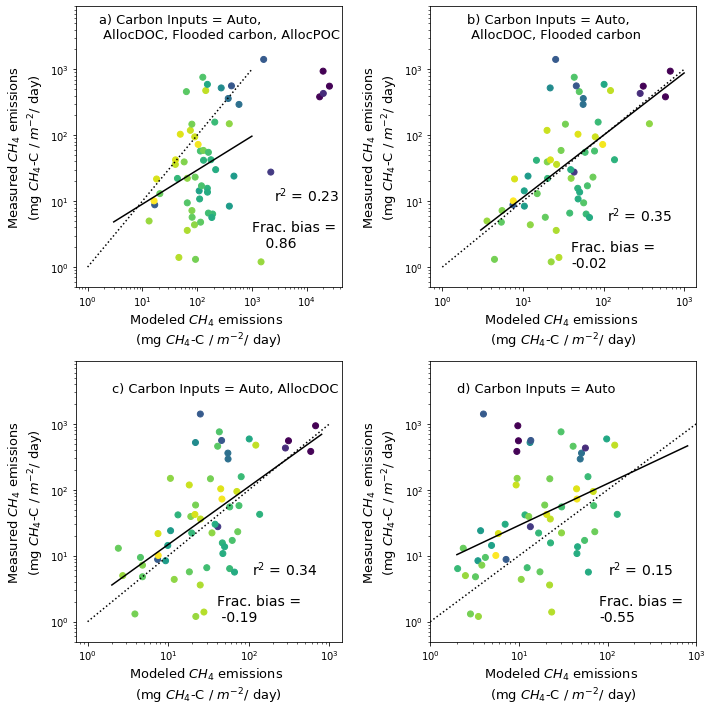

In [11]:
#*************************************************************************
#Plot ebullition and diffusion from all carbon sources
#*************************************************************************
Res_CH4['log_res_time'] = np.log(Res_CH4['Residence_Time_days'])

fig = plt.figure(figsize = [10,10])
plt.subplot(221)

plt.scatter(Res_CH4['Eb_plus_Diff_all'], Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'], c = Res_CH4['log_res_time'])#, cmap = 'Accent')
plt.xlabel('Modeled $CH_4$ emissions  \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.ylabel('Measured $CH_4$ emissions \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)

plt.plot([1,1000],[1,1000],':k')

# extract r_squared value for model/data fit
log_tot_ebdiff = np.log(Res_CH4['Eb_plus_Diff_all'])
log_fielddata_tot = np.log(Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'])
log_tot_ebdiff= sm.add_constant(log_tot_ebdiff)  #add a constant intercept so I am not forcing through 0,0
model1 = sm.OLS(log_fielddata_tot,  log_tot_ebdiff, hasconstant = True).fit()   #(y,x)
r_value1 = model1.rsquared
y1 = model1.params

x = np.arange(3, 1000)
plt.ylim(0.5, 9000)
plt.plot(x,np.exp(y1[0])*np.exp(y1[1]*np.log(x)), 'k')
plt.text(2500,10,'r$^{2}$ = ' + str(round(r_value1,2)), fontsize = 14)
plt.text(1.6,3000, 'a) Carbon Inputs = Auto,\n AllocDOC, Flooded carbon, AllocPOC', fontsize = 13)

#add fractional bias estimate to subplot
frac_bias = (2/len(Res_CH4)) * np.sum((Res_CH4['Eb_plus_Diff_all'] - Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']) / (Res_CH4['Eb_plus_Diff_all'] + Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']))
plt.text(1000,2,'Frac. bias =\n   ' + str(round(frac_bias,2)), fontsize = 14)

plt.yscale('log')
plt.xscale('log')


#*************************************************************************
#Plot ebullition and diffusion from 3 carbon sources (autochthonouc, allocthonous DOC, and flooded carbon)
#*************************************************************************
plt.subplot(222)

plt.scatter(Res_CH4['Eb_plus_Diff_auto_AllocDOC_biomass'], Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'],  c = Res_CH4['log_res_time'])#, cmap = 'Accent')
plt.xlabel('Modeled $CH_4$ emissions  \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.ylabel('Measured $CH_4$ emissions \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.yscale('log')
plt.xscale('log')
plt.plot([1,1000],[1,1000],':k')

# extract r_squared value for model/data fit
log_auto_ebdiff = np.log(Res_CH4['Eb_plus_Diff_auto_AllocDOC_biomass'])
log_fielddata_tot = np.log(Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'])
log_auto_ebdiff= sm.add_constant(log_auto_ebdiff)  #add a constant intercept so I am not forcing through 0,0
model2 = sm.OLS(log_fielddata_tot,  log_auto_ebdiff, hasconstant = True).fit()   #(y,x)
model2.summary()
r_value2 = model2.rsquared
y2 = model2.params


print( 'check this', y2[0], y2[1])
plt.ylim(0.5, 9000)
plt.plot(x,np.exp(y2[0])*np.exp(y2[1]*np.log(x)), 'k')

plt.text(110,5,'r$^{2}$ = ' + str(round(r_value2,2)), fontsize = 14)
plt.text(2, 3000, 'b) Carbon Inputs = Auto,\n AllocDOC, Flooded carbon', fontsize = 13)

#add fractional bias estimate to subplot
frac_bias = (2/len(Res_CH4)) * np.sum((Res_CH4['Eb_plus_Diff_auto_AllocDOC_biomass'] - Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']) / (Res_CH4['Eb_plus_Diff_auto_AllocDOC_biomass'] + Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']))
plt.text(40,1,'Frac. bias = \n' + str(round(frac_bias,2)), fontsize = 14)


#*************************************************************************
#Plot ebullition and diffusion from 2 carbon sources (autochthonouc and allocthonous DOC carbon)
#*************************************************************************
plt.subplot(223)

plt.scatter(Res_CH4['Eb_plus_Diff_auto_AllocDOC'], Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'],  c = Res_CH4['log_res_time'])#, cmap = 'Accent')
plt.xlabel('Modeled $CH_4$ emissions  \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.ylabel('Measured $CH_4$ emissions \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.yscale('log')
plt.xscale('log')
plt.plot([1,1000],[1,1000],':k')

# extract r_squared value for model/data fit
log_auto_ebdiff = np.log(Res_CH4['Eb_plus_Diff_auto_AllocDOC'])
log_fielddata_tot = np.log(Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'])
log_auto_ebdiff= sm.add_constant(log_auto_ebdiff)  #add a constant intercept so I am not forcing through 0,0
model3 = sm.OLS(log_fielddata_tot,  log_auto_ebdiff, hasconstant = True).fit()   #(y,x)
model3.summary()
r_value3 = model3.rsquared
y3 = model3.params

x = np.arange(2, 800)

plt.plot(x,np.exp(y3[0])*np.exp(y3[1]*np.log(x)), 'k')
plt.text(110,5,'r$^{2}$ = ' + str(round(r_value3,2)), fontsize = 14)
plt.text(2, 3000, 'c) Carbon Inputs = Auto, AllocDOC', fontsize = 13)

#add fractional bias estimate to subplot
frac_bias = (2/len(Res_CH4)) * np.sum((Res_CH4['Eb_plus_Diff_auto_AllocDOC'] - Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']) / (Res_CH4['Eb_plus_Diff_auto_AllocDOC'] + Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']))
plt.text(40,1,'Frac. bias =\n ' + str(round(frac_bias,2)), fontsize = 14)

plt.ylim(0.5, 9000)

#*************************************************************************
#Plot ebullition and diffusion from 1 carbon sources (autochthonous carbon)
#*************************************************************************
plt.subplot(224)

plt.scatter(Res_CH4['Eb_plus_Diff_auto'], Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'],  c = Res_CH4['log_res_time'])#, cmap = 'Accent')
plt.xlabel('Modeled $CH_4$ emissions  \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.ylabel('Measured $CH_4$ emissions \n(mg $CH_4$-C / $m^{-2}$/ day)', fontsize = 13)
plt.yscale('log')
plt.xscale('log')
plt.plot([1,1000],[1,1000],':k')

# extract r_squared value for model/data fit
log_auto_ebdiff = np.log(Res_CH4['Eb_plus_Diff_auto'])
log_fielddata_tot = np.log(Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1'])
log_auto_ebdiff= sm.add_constant(log_auto_ebdiff)  #add a constant intercept so I am not forcing through 0,0
model4 = sm.OLS(log_fielddata_tot,  log_auto_ebdiff, hasconstant = True).fit()   #(y,x)
model4.summary()
r_value4 = model4.rsquared
y4 = model4.params

x = np.arange(2, 800)
plt.plot(x,np.exp(y4[0])*np.exp(y4[1]*np.log(x)), 'k')
plt.text(100,5,'r$^{2}$ = ' + str(round(r_value4,2)), fontsize = 14)
plt.text(2, 3000, 'd) Carbon Inputs = Auto', fontsize = 13)

#add fractional bias estimate to subplot
frac_bias = (2/len(Res_CH4)) * np.sum((Res_CH4['Eb_plus_Diff_auto'] - Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']) / (Res_CH4['Eb_plus_Diff_auto'] + Res_CH4['Measured_CH4_eb+diff_mgCH4-C_m-2_d-1']))
plt.text(80,1,'Frac. bias = \n' + str(round(frac_bias,2)), fontsize = 14)

plt.xlim(1,1000)
plt.ylim(0.5, 9000)
plt.tight_layout()


# Plot carbon input importance

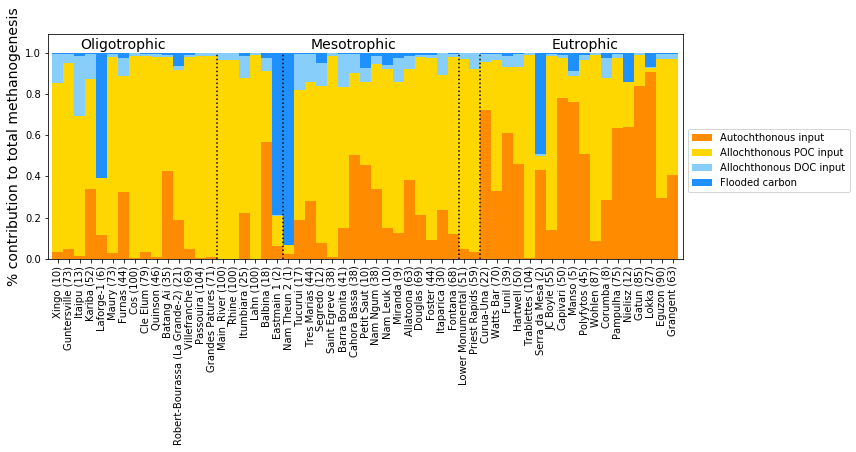

In [12]:

Res_CH4['All'] = Res_CH4.Auto_CH4_prod + Res_CH4.Alloc_POC_CH4_prod + Res_CH4.Alloc_DOC_CH4_prod + Res_CH4.Biomass_CH4_prod
total = Res_CH4.All
Res_CH4['Auto_frac'] = Res_CH4.Auto_CH4_prod/total
Res_CH4['Alloc_POC_frac'] =  Res_CH4.Alloc_POC_CH4_prod/total
Res_CH4['Alloc_DOC_frac'] =  Res_CH4.Alloc_DOC_CH4_prod/total
Res_CH4['Biomass_frac'] = Res_CH4.Biomass_CH4_prod/total
Res_CH4['Age_rounded'] = Res_CH4['Age_yrs'].astype(np.int64)
Res_CH4['System_plus_age'] = Res_CH4['System'] + ' (' + Res_CH4['Age_rounded'].astype(str) + ')'

N = len(Res_CH4)
Res_CH4.sort_values(by=['Primary_Prod'] , inplace = True) #Age_yrs
Res_CH4.reset_index(inplace = True, drop = True)
fig, ax = plt.subplots(figsize=(12,6))
Res_CH4.reset_index(inplace = True, drop = True)
ind = np.arange(N)    # the x locations for the groups

width = 1
total = Res_CH4.Auto_CH4_prod + Res_CH4.Alloc_POC_CH4_prod + Res_CH4.Alloc_DOC_CH4_prod + Res_CH4.Biomass_CH4_prod

p1 = plt.bar(ind, Res_CH4.Auto_frac, width, color = 'darkorange', label = 'Autochthonous input')

p2 = plt.bar(ind, Res_CH4.Alloc_POC_frac, width,
             bottom=Res_CH4.Auto_frac,  color = 'gold', label = 'Allochthonous POC input')

p3 = plt.bar(ind, Res_CH4.Alloc_DOC_frac, width,
             bottom=(Res_CH4.Auto_frac + Res_CH4.Alloc_POC_frac) , color = 'lightskyblue',label = 'Allochthonous DOC input')

p4 = plt.bar(ind, Res_CH4.Biomass_CH4_prod/total, width,
             bottom=(Res_CH4.Auto_frac + Res_CH4.Alloc_POC_frac  + Res_CH4.Alloc_DOC_frac),  color = 'dodgerblue', label = 'Flooded carbon')
plt.legend(bbox_to_anchor=(1.0, 0.6))
plt.xticks(ind, labels = Res_CH4.System_plus_age, rotation = 90)

#add lines for trophic status
olig =  len(Res_CH4[Res_CH4.Primary_Prod == 151])
oligmeso = olig +   len(Res_CH4[Res_CH4.Primary_Prod == 0.5*(151+570)])
meso = oligmeso + len(Res_CH4[Res_CH4.Primary_Prod ==  570])
mesoeu = meso + len(Res_CH4[Res_CH4.Primary_Prod == 0.5*(570 + 2019)])

    
plt.plot([olig-0.5,olig-0.5], [0, 1], ':k')
plt.plot([oligmeso-0.5,oligmeso-0.5], [0, 1], ':k')
plt.plot([meso-0.5,meso-0.5], [0, 1], ':k')
plt.plot([mesoeu-0.5,mesoeu-0.5], [0, 1], ':k')
# plt.plot([olig+0.5,olig+0.5], [0, 1800], ':k')
plt.text( 2, 1.02, 'Oligotrophic', fontsize = 14)
plt.text( 23, 1.02, 'Mesotrophic', fontsize = 14)
plt.text(45, 1.02, 'Eutrophic', fontsize = 14)

# plt.xlabel('Sequential Reservoir Age (youngest to oldest)')
plt.ylabel('% contribution to total methanogenesis', fontsize = 14)
plt.ylim([0,1.09])
plt.xlim([-0.9,N])
plt.tight_layout()
